In [1]:
import os
import os.path as osp
import json
import pickle
import collections as C
import itertools as I
import random
import math
from typing import Dict, List, Union, Tuple

import numpy as np
import pandas as pd
from loguru import logger
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.interpolate import make_interp_spline

from common.constants import CORE_OPTIONS
from common.utils import remove_comments, normalize_spaces, remove_spaces
from common.pantograph.dataclasses import ProblemGenerationProcess

In [2]:
def is_falsified(d: ProblemGenerationProcess) -> bool:
    if 'eval_old_result' in d.metainfo:
        if any(p is not None for p in d.metainfo['eval_old_result']['falsify_proofs']):
            return True
    assert 'eval_result' in d.metainfo
    # 'eval_result' may contain both falsifying and satisfying
    if any(p is not None for p in d.metainfo['eval_result'].get('satisfy_proofs', [None])):
        return False
    return any(p is not None for p in d.metainfo['eval_result']['falsify_proofs'])

def is_proven(d: ProblemGenerationProcess) -> bool:
    if len(d.trajectory) > 0:
        # Deductive Exploration
        return len(d.formal_statement) > 0 and d.metainfo.get('is_solution_validated')
    else:
        # Baselines
        if len(d.formal_solution_draft or '') > 0:
            return True
        if any(p is not None for p in d.metainfo.get('eval_result', dict()).get('proofs', [None])):
            for p in d.metainfo.get('eval_result', dict()).get('proofs', [None]):
                if p is not None:
                    d.formal_solution_draft = p
            # logger.warning(f"`len(d.formal_solution_draft or '') == 0` but `eval_result` is proven")
            return True
        return False

def is_valid(d: ProblemGenerationProcess) -> bool:
    return is_proven(d) and not is_falsified(d)

def count_prompt_token_cost(d: ProblemGenerationProcess) -> int:
    if len(d.trajectory) > 0:
        # Deductive Exploration
        if 'prompt_tokens' in d.metainfo.keys():
            return d.metainfo['prompt_tokens'] * d.metainfo.get('server_failure_token_discounted_ratio', 1.0)
        else:
            return sum(d.metainfo['token_usage']['prompt_tokens'][d.metainfo.get('first_failure_idx', 0):])
    else:
        # Baselines
        total_prompt_tokens = 0
        if 'token_usage' in d.metainfo and 'generate_statement' in d.metainfo['token_usage']:
            # Whole-statement generation baseline
            assert 'token_usage:stmt_autoformalizer' not in d.metainfo
            assert len(d.metainfo['token_usage']['generate_statement']) == 2
            total_prompt_tokens += d.metainfo['token_usage']['generate_statement'][1]
            if 'provers.prove' in d.metainfo['token_usage']:
                total_prompt_tokens += sum(d.metainfo['token_usage']['provers.prove']['prompt_tokens'])
        elif 'token_usage:stmt_autoformalizer' in d.metainfo:
            # Autoformalization-based baselines
            total_prompt_tokens += sum(d.metainfo['token_usage:stmt_autoformalizer']['prompt_tokens'])
            if 'eval_result' in d.metainfo.keys():
                total_prompt_tokens += sum(d.metainfo['eval_result']['prove_token_usage']['prompt_tokens'])
        else:
            # MUSTARD baseline
            total_prompt_tokens += sum(d.metainfo['eval_result']['prove_token_usage']['prompt_tokens'])
        return total_prompt_tokens

def count_token_cost(d: ProblemGenerationProcess) -> int:
    if len(d.trajectory) > 0:
        # Deductive Exploration
        if 'completion_tokens' in d.metainfo.keys():
            return d.metainfo['completion_tokens'] * d.metainfo.get('server_failure_token_discounted_ratio', 1.0)
        else:
            return sum(d.metainfo['token_usage']['completion_tokens'][d.metainfo.get('first_failure_idx', 0):])
    else:
        # Baselines
        total_completion_tokens = 0
        if 'token_usage' in d.metainfo and 'generate_statement' in d.metainfo['token_usage']:
            # Whole-statement generation baseline
            assert 'token_usage:stmt_autoformalizer' not in d.metainfo
            assert len(d.metainfo['token_usage']['generate_statement']) == 2
            total_completion_tokens += d.metainfo['token_usage']['generate_statement'][0]
            if 'provers.prove' in d.metainfo['token_usage']:
                total_completion_tokens += sum(d.metainfo['token_usage']['provers.prove']['completion_tokens'])
        elif 'token_usage:stmt_autoformalizer' in d.metainfo:
            # Autoformalization-based baselines
            # total_completion_tokens += d.metainfo['informal_token_cost_estimation']
            total_completion_tokens += sum(d.metainfo['token_usage:stmt_autoformalizer']['completion_tokens'])
            if 'eval_result' in d.metainfo.keys():
                total_completion_tokens += sum(d.metainfo['eval_result']['prove_token_usage']['completion_tokens'])
        else:
            # MUSTARD baseline
            # total_completion_tokens += d.metainfo['informal_token_cost_estimation']
            total_completion_tokens += sum(d.metainfo['eval_result']['prove_token_usage']['completion_tokens'])
        return total_completion_tokens

def count_kc(d: ProblemGenerationProcess) -> int:
    try:
        if 'proving_results' in d.metainfo:
            return len(remove_spaces(remove_comments(d.formal_solution_draft)))
        else:
            return d.metainfo['eval_result']['KC']
    except:
        # return len(remove_spaces(remove_comments(d.formal_solution_draft)))
        return float('nan')

def count_step_kc(d: ProblemGenerationProcess) -> int:
    try:
        return len(remove_spaces(remove_comments(d.formal_solution_draft)))
    except:
        return float('nan')

def count_falsifier_prompt_token_cost(d: ProblemGenerationProcess) -> int:
    try:
        return sum((sum(v) for v in d.metainfo['falsifier_token_usage']['prompt_tokens']))
    except:
        return 0

def count_falsifier_token_cost(d: ProblemGenerationProcess) -> int:
    try:
        return sum((sum(v) for v in d.metainfo['falsifier_token_usage']['completion_tokens']))
    except:
        return 0

def compute_kc_cost_validnum_curve(d: ProblemGenerationProcess) -> list[tuple[int, bool]]:
    if len(d.trajectory) > 0:   # By limiting the number of steps
        # Deductive Exploration
        # Maybe we should use re-ran script for alternative
        if 'token_usage' in d.metainfo.keys():
            max_num = max(80, len(d.metainfo['token_usage']['completion_tokens']))
            total_completion_tokens_by_proof_num = np.zeros(max_num)
            is_valid_by_proof_num = np.zeros(max_num, dtype=bool)
            assert len(d.metainfo['token_usage']['completion_tokens']) <= max_num

            is_valid_by_proof_num[len(d.metainfo['token_usage']['completion_tokens'])-1:] = is_valid(d)
            total_completion_tokens_by_proof_num = np.add.accumulate(d.metainfo['token_usage']['completion_tokens'])
            total_completion_tokens_by_proof_num = np.concatenate([total_completion_tokens_by_proof_num, [total_completion_tokens_by_proof_num[-1] for _ in range(max_num - len(total_completion_tokens_by_proof_num))]])
        else:
            max_num = max(80, d.metainfo['n_steps_total'])
            total_completion_tokens_by_proof_num = np.zeros(max_num)
            is_valid_by_proof_num = np.zeros(max_num, dtype=bool)
            # assert d.metainfo['n_steps_total'] <= max_num

            is_valid_by_proof_num[d.metainfo['n_steps_total']-1:] = is_valid(d)
            total_completion_tokens_by_proof_num = (np.arange(d.metainfo['n_steps_total']) + 1) * (d.metainfo['completion_tokens']/ d.metainfo['n_steps_total'])
            total_completion_tokens_by_proof_num = np.concatenate([total_completion_tokens_by_proof_num, [total_completion_tokens_by_proof_num[-1] for _ in range(max_num - len(total_completion_tokens_by_proof_num))]])
        if max_num > 80:
            total_completion_tokens_by_proof_num[79] = total_completion_tokens_by_proof_num[-1]
            total_completion_tokens_by_proof_num = total_completion_tokens_by_proof_num[:80]
            is_valid_by_proof_num[79] = is_valid_by_proof_num[-1]
            is_valid_by_proof_num = is_valid_by_proof_num[:80]
            
        # if 'completion_tokens' in d.metainfo.keys():
        #     return d.metainfo['completion_tokens'] * d.metainfo.get('server_failure_token_discounted_ratio', 1.0)
        # else:
        #     return sum(d.metainfo['token_usage']['completion_tokens'][d.metainfo.get('first_failure_idx', 0):])
    else:   # By limiting the number of proofs
        # Baselines
        
        max_num = 12
        total_completion_tokens_by_proof_num = np.zeros(max_num)
        is_valid_by_proof_num = np.zeros(max_num, dtype=bool)
        
        if 'token_usage' in d.metainfo and 'generate_statement' in d.metainfo['token_usage']:
            # Whole-statement generation baseline
            assert 'token_usage:stmt_autoformalizer' not in d.metainfo
            assert len(d.metainfo['token_usage']['generate_statement']) == 2
            
            # total_completion_tokens_by_proof_num += d.metainfo['token_usage']['generate_statement'][0]
            # if 'provers.prove' in d.metainfo['token_usage']:
            #     total_completion_tokens += sum(d.metainfo['token_usage']['provers.prove']['completion_tokens'])
            if 'provers.prove' in d.metainfo['token_usage'].keys():
                assert len(d.metainfo['token_usage']['provers.prove']['completion_tokens']) <= max_num
                is_valid_by_proof_num[len(d.metainfo['token_usage']['provers.prove']['completion_tokens'])-1:] = is_valid(d)
                total_completion_tokens_by_proof_num = np.add.accumulate(d.metainfo['token_usage']['provers.prove']['completion_tokens'])
                total_completion_tokens_by_proof_num = np.concatenate([total_completion_tokens_by_proof_num, [total_completion_tokens_by_proof_num[-1] for _ in range(max_num - len(total_completion_tokens_by_proof_num))]])
            
            total_completion_tokens_by_proof_num += sum(d.metainfo['token_usage']['generate_statement'])
        elif 'token_usage:stmt_autoformalizer' in d.metainfo:
            # Autoformalization-based baselines
            
            if 'eval_result' in d.metainfo.keys():
                assert len(d.metainfo['eval_result']['prove_token_usage']['completion_tokens']) <= max_num
                is_valid_by_proof_num[len(d.metainfo['eval_result']['prove_token_usage']['completion_tokens'])-1:] = is_valid(d)
                total_completion_tokens_by_proof_num = np.add.accumulate(d.metainfo['eval_result']['prove_token_usage']['completion_tokens'])
                total_completion_tokens_by_proof_num = np.concatenate([total_completion_tokens_by_proof_num, [total_completion_tokens_by_proof_num[-1] for _ in range(max_num - len(total_completion_tokens_by_proof_num))]])
            
            # total_completion_tokens_by_proof_num += d.metainfo['informal_token_cost_estimation']
            total_completion_tokens_by_proof_num += sum(d.metainfo['token_usage:stmt_autoformalizer']['completion_tokens'])
        else:
            # MUSTARD baseline
            assert len(d.metainfo['eval_result']['prove_token_usage']['completion_tokens']) <= max_num
            is_valid_by_proof_num[len(d.metainfo['eval_result']['prove_token_usage']['completion_tokens'])-1:] = is_valid(d)
            total_completion_tokens_by_proof_num = np.add.accumulate(d.metainfo['eval_result']['prove_token_usage']['completion_tokens'])
            total_completion_tokens_by_proof_num = np.concatenate([total_completion_tokens_by_proof_num, [total_completion_tokens_by_proof_num[-1] for _ in range(max_num - len(total_completion_tokens_by_proof_num))]])
            # total_completion_tokens_by_proof_num += d.metainfo['informal_token_cost_estimation']
                
    return total_completion_tokens_by_proof_num, is_valid_by_proof_num


In [3]:
output_root = '/home/ma-user/workspace/formal_problem_generation/output_tmp/output'

results_settings = []

# Numina-Lean-reasseblmed.39509.problem_generator
exp_name = 'Deductive Explorer'
path_prefix = 'sft_ar_v3/Goedel-Prover-V2-8B.Numina-Lean-reasseblmed.39509.problem_generator.nopack.3epoch'
load_path = osp.join(
    output_root, path_prefix,
    'fpg_evaluate_kc.20250913-004304.pkl'
)
log_path = osp.join(
    output_root, path_prefix,
    'problem_generation.20250909-090734.log'
)
results_settings.append((exp_name, path_prefix, load_path, log_path))

# Main (Repeated)
exp_name = 'Our Method (Repeated)'
path_prefix = 'sft_ar_v3/Goedel-Prover-V2-8B.Numina-Lean-reasseblmed.39509.problem_generator.nopack.3epoch.0913'
load_path = osp.join(
    output_root, path_prefix,
    'fpg_evaluate_falsify_prove.20250913-220057.pkl'
)
log_path = osp.join(
    output_root, path_prefix,
    'problem_generation.20250913-124624.log'
)
results_settings.append((exp_name, path_prefix, load_path, log_path))

# Ablation (-Order)
exp_name = 'Deductive Explorer (S)'
path_prefix = 'sft_ar_v3/Goedel-Prover-V2-8B.Numina-Lean-reasseblmed.39509.problem_generator.nopack.3epoch.0913.staged'
load_path = osp.join(
    output_root, path_prefix,
    'fpg_evaluate_falsify_prove.20250914-104447.pkl'
)
log_path = osp.join(
    output_root, path_prefix,
    'staged_problem_generation.20250913-214247.log'
)
results_settings.append((exp_name, path_prefix, load_path, log_path))

# Numina-Lean.whole_statement_generatior
exp_name = 'Conjecture-Prover'
path_prefix = 'sft_wg_starified/Goedel-Prover-V2-8B.Numina-Lean.whole_statement_generatior.nopack'
load_path = osp.join(
    output_root, path_prefix,
    'fpg_evaluate_falsify_prove.20250911-162131.pkl'
)
log_path = osp.join(
    output_root, path_prefix,
    'problem_generation.20250909-232315.log'
)
results_settings.append((exp_name, path_prefix, load_path, log_path))


# PromptCoT-QwQ_kimina7b
exp_name = 'PromptCoT-QwQ'
path_prefix = 'autoformalization_pg_kimina7b/PromptCoT-QwQ_kimina7b'
load_path = osp.join(
    output_root, path_prefix,
    'fpg_evaluate_falsify_prove.20250911-154953.pkl'
)
log_path = osp.join(
    output_root, path_prefix,
    'fpg_evaluate_falsify_prove.20250911-154953.log'
)
results_settings.append((exp_name, path_prefix, load_path, log_path))

# PromptCoT-DS_kimina7b
exp_name = 'PromptCoT-DS'
path_prefix = 'autoformalization_pg_kimina7b/PromptCoT-DS_kimina7b'
load_path = osp.join(
    output_root, path_prefix,
    'fpg_evaluate_falsify_prove.20250911-154956.pkl'
)
log_path = osp.join(
    output_root, path_prefix,
    'fpg_evaluate_falsify_prove.20250911-154956.log'
)
results_settings.append((exp_name, path_prefix, load_path, log_path))

# ScaleQuest-Math_kimina7b
exp_name = 'ScaleQuest-Math'
path_prefix = 'autoformalization_pg_kimina7b/ScaleQuest-Math_kimina7b'
load_path = osp.join(
    output_root, path_prefix,
    'fpg_evaluate_falsify_prove.20250911-154955.pkl'
)
log_path = osp.join(
    output_root, path_prefix,
    'fpg_evaluate_falsify_prove.20250911-154955.log'
)
results_settings.append((exp_name, path_prefix, load_path, log_path))

# MUSTARDSauce_lean4_parsed
exp_name = 'MUSTARD'
path_prefix = 'MUSTARDSauce_lean4_parsed'
load_path = osp.join(
    output_root, path_prefix,
    'fpg_evaluate_falsify_prove.20250911-121840.pkl'
)
log_path = osp.join(
    output_root, path_prefix,
    'fpg_evaluate_falsify_prove.20250911-121840.log'
)
results_settings.append((exp_name, path_prefix, load_path, log_path))

In [7]:
for (exp_name, path_prefix, load_path, log_path) in results_settings:
    print(f'''python -m evaluator.fpg_evaluate_trivial \\
    --load_path "{load_path}" \\
    --log_root "/home/ma-user/workspace/formal_problem_generation/output_tmp/collection/{exp_name}" \\
    --num_concurrency 64 \\
    --debug False''')
    print()

python -m evaluator.fpg_evaluate_trivial \
    --load_path "/home/ma-user/workspace/formal_problem_generation/output_tmp/output/sft_ar_v3/Goedel-Prover-V2-8B.Numina-Lean-reasseblmed.39509.problem_generator.nopack.3epoch/fpg_evaluate_kc.20250913-004304.pkl" \
    --log_root "/home/ma-user/workspace/formal_problem_generation/output_tmp/collection/Deductive Explorer" \
    --num_concurrency 64 \
    --debug False

python -m evaluator.fpg_evaluate_trivial \
    --load_path "/home/ma-user/workspace/formal_problem_generation/output_tmp/output/sft_ar_v3/Goedel-Prover-V2-8B.Numina-Lean-reasseblmed.39509.problem_generator.nopack.3epoch.0913/fpg_evaluate_falsify_prove.20250913-220057.pkl" \
    --log_root "/home/ma-user/workspace/formal_problem_generation/output_tmp/collection/Our Method (Repeated)" \
    --num_concurrency 64 \
    --debug False

python -m evaluator.fpg_evaluate_trivial \
    --load_path "/home/ma-user/workspace/formal_problem_generation/output_tmp/output/sft_ar_v3/Goedel-Prover

In [ ]:
exp_results = dict()

for (exp_name, path_prefix, load_path, log_path) in results_settings:
    failure_steps = C.defaultdict(list)
    max_steps = dict()
    with open(load_path, 'rb') as f:
        (conditions, finished_list) = pickle.load(f)
    
    with open(log_path, 'r') as f:
        for l in f.readlines():
            l = l.strip()
            if 'agent.problem_generation:generate_async' in l and l.endswith('failed due to AssertionError()'):
                e = l.split()
                assert e[7].startswith('generate_async(') and e[7].endswith('):')
                gen_idx = int(e[7][len('generate_async('):-len('):')])
                step_idx = int(e[8].split('/')[0])
                failure_steps[gen_idx].append(step_idx)
            if 'agent.problem_generation:generate_async:839' in l and l.endswith(', State'):
                e = l.split()[8]
                gen_idx = int(l.split()[7][len('generate_async('):-len('):')])
                assert e.endswith(',')
                step_idx, tot_idx = e[:-1].split('/')
                step_idx, tot_idx = int(step_idx), int(tot_idx)
                assert tot_idx == 80
                if gen_idx not in max_steps.keys():
                    max_steps[gen_idx] = step_idx
                else:
                    max_steps[gen_idx] = max(max_steps[gen_idx], step_idx)

    for d in finished_list:
        try:
            d.metainfo = json.loads(d.metainfo)
        except:
            pass

    if exp_name == 'MUSTARD':
        conditions, finished_list = [c for (c, d) in zip(conditions, finished_list) if 'eval_result' in d.metainfo.keys()], [d for (c, d) in zip(conditions, finished_list) if 'eval_result' in d.metainfo.keys()]

    print(exp_name, path_prefix, len(conditions), len(finished_list), len(failure_steps))

    for (gen_idx, step_idx_list) in failure_steps.items():
        if step_idx_list == list(range(step_idx_list[0], 81)):
            # print(f'True, {gen_idx}')
            assert len(finished_list[gen_idx].steps) < step_idx_list[0]
            finished_list[gen_idx].metainfo['server_failure_token_discounted_ratio'] = (1 - len(step_idx_list) / 80)
            finished_list[gen_idx].metainfo['first_failure_idx'] = step_idx_list[0] - 1
            # print(len(step_idx_list) / 80)
        else:
            print(f'False, {gen_idx}, {len(set(range(step_idx_list[0], 81))-set(step_idx_list))}')
    
    for (gen_idx, step_idx) in max_steps.items():
        finished_list[gen_idx].metainfo['n_steps_total'] = step_idx + 1 - len(failure_steps[gen_idx])
    
    exp_results[exp_name] = finished_list
    
    # with open(
    #     osp.join('/sfs/liuqi/data/fpg_valid_formal', path_prefix.replace('/', '-') + '-valid_samples.jsonl'), 'w'
    # ) as f:
    #     for i, (c, d) in enumerate(zip(conditions, finished_list)):
    #         if not is_valid(d):
    #             continue
    #         d: ProblemGenerationProcess
    #         assert len(d.formal_statement or '') > 0
    #         assert len(d.formal_solution_draft or '') > 0
    #         f.write(json.dumps({
    #             'header': d.header or '',
    #             'formal_statement': d.formal_statement,
    #             'formal_proof': d.formal_solution_draft,
    #             'condition': c,
    #             'index': i,
    #             'src': path_prefix,
    #             'kc': count_kc(d),
    #             'token_cost': count_prompt_token_cost(d)
    #         }) + '\n')

In [ ]:
print(
    'Method', '#All', '#Submitted', '#Proven', '#Falsified', '#Valid',
    # 'Prompt Token Cost',
    'Token Cost',
    # 'Falsifier Prompt Token Cost', 'Falsifier Token Cost',
    'Complexity (Proof)',  'Complexity (Gen)',
    'Top-100 Complexity', 'Top-500 Complexity (Gen)',
    '#Inf',
    sep='\t')
for (exp_name, finished_list) in exp_results.items():
    submitted_list = [d for d in finished_list if len(d.formal_statement or '') > 0]
    falsified_list = [d for d in submitted_list if is_falsified(d)]
    proven_list = [d for d in submitted_list if is_proven(d)]
    valid_list = [d for d in submitted_list if is_valid(d)]
    # prompt_token_cost_list = [count_prompt_token_cost(d) for d in finished_list]
    token_cost_list = [count_token_cost(d) for d in finished_list]
    # falsifier_prompt_token_cost_list = [count_falsifier_prompt_token_cost(d) for d in finished_list]
    # falsifier_token_cost_list = [count_falsifier_token_cost(d) for d in finished_list]
    kc_list = [count_kc(d) for d in valid_list]
    n_inf = len([kc for kc in kc_list if kc == float('inf')])
    finite_kc_list = sorted([kc for kc in kc_list if kc != float('inf')])
    step_kc_list = sorted([count_step_kc(d) for d in valid_list])

    # finite_kc_list.sort()
    block = len(finite_kc_list) // 3
    

    print(exp_name,
        len(finished_list), len(submitted_list), len(proven_list), len(falsified_list), len(valid_list),
        # sum(prompt_token_cost_list)/len(valid_list),
        sum(token_cost_list)/len(valid_list),
        # sum(falsifier_prompt_token_cost_list)/len(valid_list), sum(falsifier_token_cost_list)/len(valid_list),
        sum(finite_kc_list)/len(finite_kc_list),
        sum(step_kc_list)/len(step_kc_list),
        # sum(finite_kc_list[-1000:])/len(finite_kc_list[-1000:]), sum(step_kc_list[-1000:])/len(step_kc_list[-1000:]),
        sum(finite_kc_list[-100:])/len(finite_kc_list[-100:]), sum(finite_kc_list[-500:])/len(finite_kc_list[-500:]),
        
        
        # np.mean(finite_kc_list), np.std(finite_kc_list),
        n_inf,
        sep='\t')

In [ ]:
cost_valid_by_k_all = dict()

for (exp_name, finished_list) in exp_results.items():
    cost_valid_by_k = [
        (compute_kc_cost_validnum_curve(d), d) for d in finished_list
    ]
    max_num = max(len(cost_list) for ((cost_list, is_valid_list), d) in cost_valid_by_k)
    cost_valid_by_k_all[exp_name] = cost_valid_by_k
    print(exp_name, max_num)
    # for k in range(max_num):
    #     cost = sum(cost_list[k] for ((cost_list, is_valid_list), d) in cost_valid_by_k)
    #     valid_list_k = [
    #         d for ((cost_list, is_valid_list), d) in cost_valid_by_k if is_valid_list[k]
    #     ]
    #     if len(valid_list_k) == 0:
    #         continue
    #     kc_list_k = [count_kc(d) for d in valid_list_k]
    #     finite_kc_list_k = [kc for kc in kc_list_k if kc != float('inf')]
        
    #     avg_complexity = sum(finite_kc_list_k) / len(finite_kc_list_k)
    #     print(k, cost, len(valid_list_k), avg_complexity, len(kc_list_k) - len(finite_kc_list_k), sep='\t')

In [ ]:
raise

## Visualization

In [ ]:
# NAME_MAPPING = {
#     "autoformalization_pg_kimina7b-PromptCoT-DS_kimina7b-valid_samples.jsonl" : "PromptCoT-DS",
#     "autoformalization_pg_kimina7b-PromptCoT-QwQ_kimina7b-valid_samples.jsonl" : "PromptCoT-QwQ",
#     "autoformalization_pg_kimina7b-ScaleQuest-Math_kimina7b-valid_samples.jsonl" : "ScaleQuest-Math",
#     "MUSTARDSauce_lean4_parsed-valid_samples.jsonl" : "MUSTARD",
#     "MUSTARDSauce_lean4_parsed-nocomment-valid_samples.jsonl" : "MUSTARD (w/o comment)",
#     "sft_ar_v3-Goedel-Prover-V2-8B.Numina-Lean-reasseblmed.39509.problem_generator.nopack.3epoch.0913.staged-valid_samples.jsonl" : "Ablation (Staged)",
#     "sft_ar_v3-Goedel-Prover-V2-8B.Numina-Lean-reasseblmed.39509.problem_generator.nopack.3epoch-valid_samples.jsonl" : "Main",
#     "sft_wg_starified-Goedel-Prover-V2-8B.Numina-Lean.whole_statement_generatior.nopack-valid_samples.jsonl" : "Conjecture-Prover"
# }

In [ ]:
labels, n_valids, accumulated_cost, avg_complexity = [], [], [], []
for (exp_name, cost_valid_by_k) in cost_valid_by_k_all.items():
    if exp_name == 'Our Method (Repeated)':
        continue
    max_num = max(len(cost_list) for ((cost_list, is_valid_list), d) in cost_valid_by_k)
    for k in range(max_num):
        if exp_name == 'Deductive Explorer':
            cost = sum(cost_list[k] for ((cost_list, is_valid_list), d) in cost_valid_by_k_all['Our Method (Repeated)'])
        else:
            cost = sum(cost_list[k] for ((cost_list, is_valid_list), d) in cost_valid_by_k)
        valid_list_k = [
            d for ((cost_list, is_valid_list), d) in cost_valid_by_k if is_valid_list[k]
        ]
        if len(valid_list_k) == 0:
            continue
        kc_list_k = [count_kc(d) for d in valid_list_k]
        finite_kc_list_k = [kc for kc in kc_list_k if kc != float('inf')]
        
        labels.append(exp_name)
        n_valids.append(len(valid_list_k))
        accumulated_cost.append(cost)
        avg_complexity.append(sum(finite_kc_list_k) / len(finite_kc_list_k))

In [ ]:
n_valids_by_exp, accumulated_cost_by_exp, avg_complexity_by_exp = C.defaultdict(list), C.defaultdict(list), C.defaultdict(list)
for (exp_name, cost_valid_by_k) in cost_valid_by_k_all.items():
    if exp_name == 'Our Method (Repeated)':
        continue
    max_num = max(len(cost_list) for ((cost_list, is_valid_list), d) in cost_valid_by_k)
    for k in range(max_num):
        if exp_name == 'Deductive Explorer':
            cost = sum(cost_list[k] for ((cost_list, is_valid_list), d) in cost_valid_by_k_all['Our Method (Repeated)'])
        else:
            cost = sum(cost_list[k] for ((cost_list, is_valid_list), d) in cost_valid_by_k)
        valid_list_k = [
            d for ((cost_list, is_valid_list), d) in cost_valid_by_k if is_valid_list[k]
        ]
        if len(valid_list_k) == 0:
            continue
        kc_list_k = [count_kc(d) for d in valid_list_k]
        finite_kc_list_k = [kc for kc in kc_list_k if kc != float('inf')]
        
        n_valids_by_exp[exp_name].append(len(valid_list_k))
        accumulated_cost_by_exp[exp_name].append(cost)
        avg_complexity_by_exp[exp_name].append(sum(finite_kc_list_k) / len(finite_kc_list_k))

In [ ]:
len(labels), len(n_valids), len(accumulated_cost), len(avg_complexity)

In [66]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import math

all_data = []

data_line = C.defaultdict(
    lambda : (list(), list())
)

for (exp_name, cost_valid_by_k) in cost_valid_by_k_all.items():
    if exp_name == 'Our Method (Repeated)':
        continue
    # if 'mustard' in exp_name.lower():
    #     continue
    max_num = max(len(cost_list) for ((cost_list, is_valid_list), d) in cost_valid_by_k)
    for k in range(max_num):
        if exp_name == 'Deductive Explorer':
            cost = sum(cost_list[k] for ((cost_list, is_valid_list), d) in cost_valid_by_k_all['Our Method (Repeated)'])
        else:
            cost = sum(cost_list[k] for ((cost_list, is_valid_list), d) in cost_valid_by_k)
        valid_list_k = [
            d for ((cost_list, is_valid_list), d) in cost_valid_by_k if is_valid_list[k]
        ]
        if len(valid_list_k) == 0:
            continue
        kc_list_k = [count_kc(d) for d in valid_list_k]
        finite_kc_list_k = [kc for kc in kc_list_k if kc != float('inf')]
        
        # labels.append(exp_name)
        # n_valids.append(len(valid_list_k))
        # accumulated_cost.append(cost)
        # avg_complexity.append(sum(finite_kc_list_k) / len(finite_kc_list_k))
        
        # if (k % 2 == 1 and max_num == 12) or ((k in [1, 4, 16, 32, 64, 80] and max_num == 80)):
        if (k in [0, 1, 3, 7, 11] and max_num == 12 and 'mustard' in exp_name.lower()) or (k in [0, 1, 3, 7, 11] and max_num == 12 and 'mustard' not in exp_name.lower()) or ((k in [3, 7, 15, 31, 79] and max_num == 80)):
            budget_data = pd.DataFrame({
                "Method": exp_name,
                "Total Cost": math.log10(cost),
                "Average Cost": cost / len(finite_kc_list_k),
                # "题目ID": [f"{method_name}_{budget:.1f}_{i+1}" for i in range(q_count)],  # 唯一ID
                # "Complexity": finite_kc_list_k
                "Complexity": [min(kc, 1500) for kc in finite_kc_list_k]
            })
            print(exp_name, max_num, k, len(budget_data))
            all_data.append(budget_data)
        
            data_line[exp_name][0].append(math.log10(cost))
            data_line[exp_name][1].append((len(valid_list_k)/5000*100) if 'mustard' not in exp_name.lower() else (len(valid_list_k)/28316*100))

# data_line = pd.concat(data_line, ignore_index=True)
data_line ={k : v for (k, v) in data_line.items()}
data = pd.concat(all_data, ignore_index=True)
# 假设data包含：方法、预算等级（1-5）、难度、题目ID


Deductive Explorer 80 3 60
Deductive Explorer 80 7 419
Deductive Explorer 80 15 1338
Deductive Explorer 80 31 2120
Deductive Explorer 80 79 2666
Deductive Explorer (S) 80 3 109
Deductive Explorer (S) 80 7 523
Deductive Explorer (S) 80 15 1257
Deductive Explorer (S) 80 31 1839
Deductive Explorer (S) 80 79 2290
Conjecture-Prover 12 0 725
Conjecture-Prover 12 1 961
Conjecture-Prover 12 3 1075
Conjecture-Prover 12 7 1138
Conjecture-Prover 12 11 1164
PromptCoT-QwQ 12 0 508
PromptCoT-QwQ 12 1 730
PromptCoT-QwQ 12 3 890
PromptCoT-QwQ 12 7 978
PromptCoT-QwQ 12 11 1024
PromptCoT-DS 12 0 179
PromptCoT-DS 12 1 288
PromptCoT-DS 12 3 371
PromptCoT-DS 12 7 430
PromptCoT-DS 12 11 457
ScaleQuest-Math 12 0 1579
ScaleQuest-Math 12 1 1936
ScaleQuest-Math 12 3 2003
ScaleQuest-Math 12 7 2023
ScaleQuest-Math 12 11 2035
MUSTARD 12 0 3578
MUSTARD 12 1 3747
MUSTARD 12 3 3779
MUSTARD 12 7 3787
MUSTARD 12 11 3789


In [67]:
with open('cost_valid_complexity.data.pkl', 'wb') as f:
    pickle.dump((data, data_line), f)

/tmp/ipykernel_1512043/3754284173.py:93: UserWarning: The palette list has more values (7) than needed (1), which may not be intended.
  sns.violinplot(x="Total Cost", y="Complexity", hue="Method", data=data_rest_5000[data_rest_5000['Method'] == 'Deductive Explorer'],


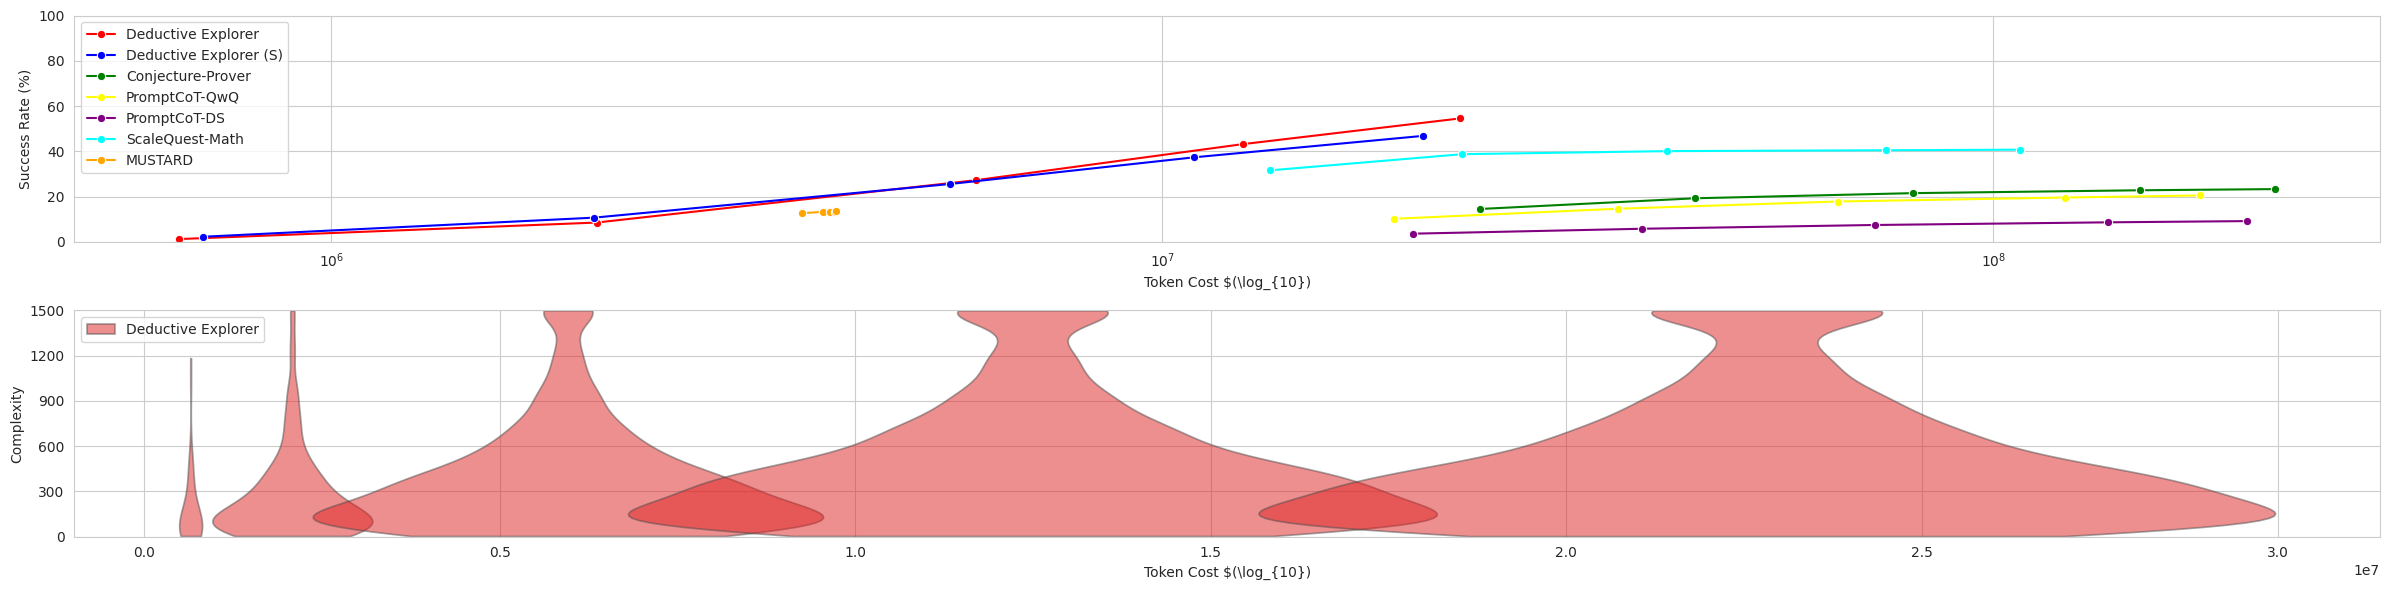

In [59]:
# with open('cost_valid_complexity.data.pkl', 'rb') as f:
#     (data, data_line) = pickle.load(f)

# sns.set_style("whitegrid")
# plt.figure(figsize=(24, 6))

# colors = ["red", "blue", "green", "yellow", "purple", 'cyan', 'orange', 'purple']
# # 绘制小提琴图

# ax = plt.gca()
# ax.set_ylim(0, 100)
# ax.set_xlabel(r'Token Cost $(\log_{10})')
# ax.set_ylabel('Perentage of Valid Statements (%)')

# data_mustard_28316 = data[data['Method'] == 'MUSTARD']
# data_rest_5000 = data[data['Method'] != 'MUSTARD']

# ax2 = ax.twinx()
# sns.violinplot(x="Total Cost", y="Complexity", hue="Method", data=data_rest_5000, 
#     inner=None,  # 不显示均值线，避免干扰
#     native_scale=True,
#     density_norm='count',
#     common_norm=True,
#     # log_scale=True,
#     width=20,
#     palette=colors,
#     alpha=0.5,
#     # showextrema=False
#     cut=0,
#     ax=ax2
#     )
# sns.violinplot(x="Total Cost", y="Complexity", hue="Method", data=data_mustard_28316, 
#     inner=None,  # 不显示均值线，避免干扰
#     native_scale=True,
#     density_norm='count',
#     common_norm=True,
#     # log_scale=True,
#     width=20/28316*5000,
#     palette=[colors[-1]],
#     alpha=0.5,
#     # showextrema=False
#     cut=0,
#     ax=ax2
#     )
# ax2.set_ylim(0, 1500)
# ax2.set_yticks([i * 300 for i in range(6)])
# ax2.set_ylabel('Complexity')
# ax2.legend(loc='upper left', title='')

# for i, (label, (x_data, y_data)) in enumerate(data_line.items()):
#     sns.lineplot(x=x_data, y=y_data, label=label, marker='o', color=colors[i], alpha=1.0, ax=ax)
# ax.get_legend().remove()

# # plt.title("Distribution")
# # plt.show()
# plt.tight_layout()
# plt.savefig('./cost_valid_complexity.data.pdf')
from matplotlib.backends.backend_pdf import PdfPages

with open('cost_valid_complexity.data.pkl', 'rb') as f:
    (data, data_line) = pickle.load(f)

sns.set_style("whitegrid")
colors = ["red", "blue", "green", "yellow", "purple", 'cyan', 'orange']
data_mustard_28316 = data[data['Method'] == 'MUSTARD']
data_rest_5000 = data[data['Method'] != 'MUSTARD']

# fig, (ax1, ax2) = plt.figure(figsize=(24, 6))
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(24, 6))

# plt.subplot(2, 1, 1)

ax1.set_ylim(0, 100)
ax1.set_ylabel('Success Rate (%)')
ax1.set_xlabel(r'Token Cost $(\log_{10})')

for i, (label, (x_data, y_data)) in enumerate(data_line.items()):
    sns.lineplot(x=x_data, y=y_data, label=label, marker='o', color=colors[i], alpha=1.0, ax=ax1)
ax1.legend(loc='upper left', title='')
ax1.set_xscale('log')
# plt.figure(figsize=(24, 3))
# 绘制小提琴图
# plt.subplot(2, 1, 2)

# ax = plt.gca()


ax2.set_xlabel(r'Token Cost $(\log_{10})')
plt.tight_layout()
# plt.savefig('./cost_valid_percent.pdf')

# ax2 = ax.twinx()
sns.violinplot(x="Total Cost", y="Complexity", hue="Method", data=data_rest_5000[data_rest_5000['Method'] == 'Deductive Explorer'], 
    inner=None,  # 不显示均值线，避免干扰
    native_scale=True,
    density_norm='count',
    common_norm=True,
    # log_scale=True,
    width=10,
    palette=colors,
    alpha=0.5,
    # inner='point',
    # showextrema=False
    cut=0,
    ax=ax2
    )
# sns.violinplot(x="Average Cost", y="Complexity", hue="Method", data=data_mustard_28316, 
#     inner=None,  # 不显示均值线，避免干扰
#     native_scale=True,
#     density_norm='count',
#     common_norm=True,
#     # log_scale=True,
#     width=20/28316*5000,
#     palette=[colors[-1]],
#     alpha=0.5,
#     # inner='point',
#     # showextrema=False
#     cut=0,
#     ax=ax2
#     )
ax2.set_ylim(0, 1500)
ax2.set_yticks([i * 300 for i in range(6)])
ax2.set_ylabel('Complexity')

ax2.legend(loc='upper left', title='')
# ax2.get_legend().remove()

# plt.title("Distribution")
# plt.show()
plt.tight_layout()


# with PdfPages('subplot1.pdf') as pdf:
#     # 创建一个新图并复制第一个子图的内容
#     fig1 = plt.figure(figsize=(24, 3))
#     ax1_copy = fig1.add_subplot(111)
#     for line in ax1.get_lines():
#         ax1_copy.plot(line.get_xdata(), line.get_ydata(), 
#                      label=line.get_label(), 
#                      color=line.get_color(),
#                      marker='o')
#     ax1_copy.set_ylim(ax1.get_ylim())
#     ax1_copy.set_xlabel(ax1.get_xlabel())
#     ax1_copy.set_ylabel(ax1.get_ylabel())
#     ax1_copy.legend(loc='upper left', title='')
#     plt.tight_layout()
#     pdf.savefig(fig1)
#     plt.close(fig1)

# with PdfPages('subplot2.pdf') as pdf:
#     # 创建一个新图并复制第二个子图的内容
#     fig2 = plt.figure(figsize=(24, 3))
#     ax2_copy = fig2.add_subplot(111)
    
#     # 复制小提琴图
#     for collection in ax2.collections:
#         new_collection = ax2_copy.collections[-1] if ax2_copy.collections else None
#         if new_collection:
#             new_collection.set_offsets(collection.get_offsets())
#             new_collection.set_paths(collection.get_paths())
#             new_collection.set_facecolor(collection.get_facecolor())
#             new_collection.set_alpha(collection.get_alpha())
    
#     sns.violinplot(x="Average Cost", y="Complexity", hue="Method", data=data_rest_5000, 
#         inner=None,  # 不显示均值线，避免干扰
#         native_scale=True,
#         density_norm='count',
#         common_norm=True,
#         # log_scale=True,
#         width=20,
#         palette=colors,
#         alpha=0.5,
#         # showextrema=False
#         # inner='point',
#         bw_adjust=0.1,
#         cut=0,
#         ax=ax2_copy
#         )
#     sns.violinplot(x="Average Cost", y="Complexity", hue="Method", data=data_mustard_28316, 
#         inner=None,  # 不显示均值线，避免干扰
#         native_scale=True,
#         density_norm='count',
#         common_norm=True,
#         # log_scale=True,
#         width=20/28316*5000,
#         palette=[colors[-1]],
#         alpha=0.5,
#         # showextrema=False
#         # inner='point',
#         bw_adjust=0.1,
#         cut=0,
#         ax=ax2_copy
#         )
    
#     ax2_copy.set_ylim(ax2.get_ylim())
#     ax2_copy.set_xlabel(ax2.get_xlabel())
#     ax2_copy.set_ylabel('')
#     ax2_copy.legend(loc='upper left', title='')
#     ax2_copy.set_yticks(ax2.get_yticks())
#     plt.tight_layout()
#     pdf.savefig(fig2)
#     plt.close(fig2)

plt.savefig('./cost_valid_complexity.data.pdf')

In [54]:
data_line['Deductive Explorer']

([656020.0, 2085798.0, 5960837.0, 12492148.0, 22817669.0],
 [1.2, 8.5, 27.200000000000003, 43.14, 54.52])

/tmp/ipykernel_1512043/2248504331.py:35: UserWarning: The palette list has more values (7) than needed (6), which may not be intended.
  sns.violinplot(x="Total Cost", y="Complexity", hue="Method", data=data_rest_5000,


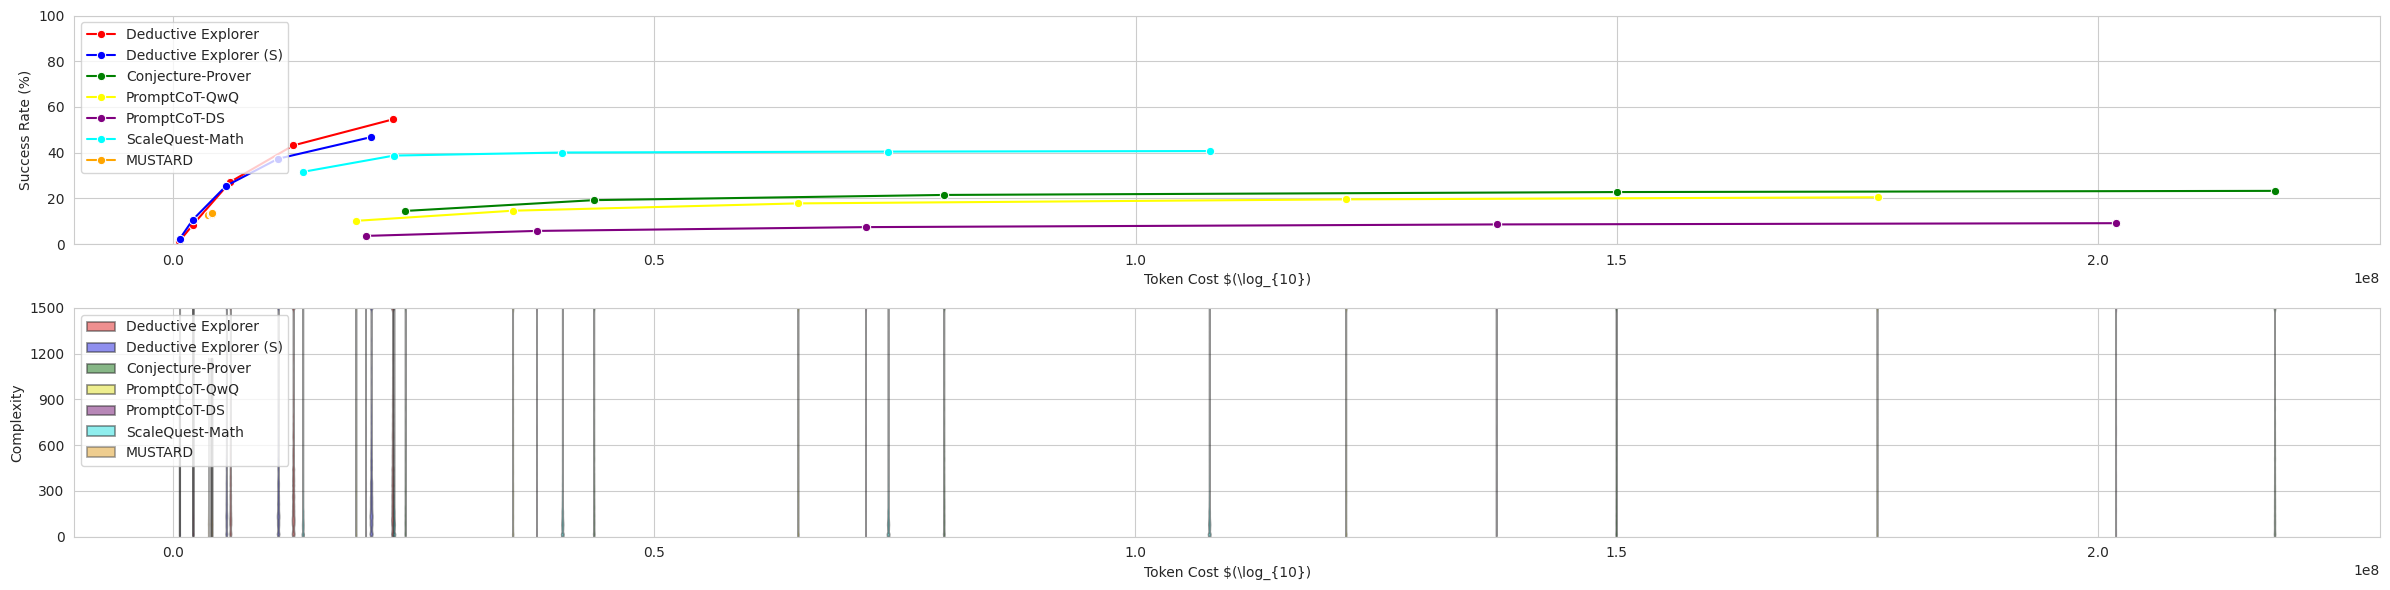

In [45]:
from matplotlib.backends.backend_pdf import PdfPages

with open('cost_valid_complexity.data.pkl', 'rb') as f:
    (data, data_line) = pickle.load(f)

sns.set_style("whitegrid")
colors = ["red", "blue", "green", "yellow", "purple", 'cyan', 'orange']
data_mustard_28316 = data[data['Method'] == 'MUSTARD']
data_rest_5000 = data[data['Method'] != 'MUSTARD']

# fig, (ax1, ax2) = plt.figure(figsize=(24, 6))
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(24, 6))

# plt.subplot(2, 1, 1)

ax1.set_ylim(0, 100)
ax1.set_ylabel('Success Rate (%)')
ax1.set_xlabel(r'Token Cost $(\log_{10})')

for i, (label, (x_data, y_data)) in enumerate(data_line.items()):
    sns.lineplot(x=x_data, y=y_data, label=label, marker='o', color=colors[i], alpha=1.0, ax=ax1)
ax1.legend(loc='upper left', title='')
# plt.figure(figsize=(24, 3))
# 绘制小提琴图
# plt.subplot(2, 1, 2)

# ax = plt.gca()


ax2.set_xlabel(r'Token Cost $(\log_{10})')
plt.tight_layout()
# plt.savefig('./cost_valid_percent.pdf')

# ax2 = ax.twinx()
sns.violinplot(x="Total Cost", y="Complexity", hue="Method", data=data_rest_5000, 
    inner=None,  # 不显示均值线，避免干扰
    native_scale=True,
    density_norm='count',
    common_norm=True,
    # log_scale=True,
    width=20,
    palette=colors,
    alpha=0.5,
    # inner='point',
    bw_adjust=0.1,
    # showextrema=False
    cut=0,
    ax=ax2
    )
sns.violinplot(x="Total Cost", y="Complexity", hue="Method", data=data_mustard_28316, 
    inner=None,  # 不显示均值线，避免干扰
    native_scale=True,
    density_norm='count',
    common_norm=True,
    # log_scale=True,
    width=20/28316*5000,
    palette=[colors[-1]],
    alpha=0.5,
    # inner='point',
    bw_adjust=0.1,
    # showextrema=False
    cut=0,
    ax=ax2
    )
ax2.set_ylim(0, 1500)
ax2.set_yticks([i * 300 for i in range(6)])
ax2.set_ylabel('Complexity')

ax2.legend(loc='upper left', title='')
# ax2.get_legend().remove()

# plt.title("Distribution")
# plt.show()
plt.tight_layout()


# with PdfPages('subplot1.pdf') as pdf:
#     # 创建一个新图并复制第一个子图的内容
#     fig1 = plt.figure(figsize=(24, 3))
#     ax1_copy = fig1.add_subplot(111)
#     for line in ax1.get_lines():
#         ax1_copy.plot(line.get_xdata(), line.get_ydata(), 
#                      label=line.get_label(), 
#                      color=line.get_color(),
#                      marker='o')
#     ax1_copy.set_ylim(ax1.get_ylim())
#     ax1_copy.set_xlabel(ax1.get_xlabel())
#     ax1_copy.set_ylabel(ax1.get_ylabel())
#     ax1_copy.legend(loc='upper left', title='')
#     plt.tight_layout()
#     pdf.savefig(fig1)
#     plt.close(fig1)

# with PdfPages('subplot2.pdf') as pdf:
#     # 创建一个新图并复制第二个子图的内容
#     fig2 = plt.figure(figsize=(24, 3))
#     ax2_copy = fig2.add_subplot(111)
    
#     # 复制小提琴图
#     for collection in ax2.collections:
#         new_collection = ax2_copy.collections[-1] if ax2_copy.collections else None
#         if new_collection:
#             new_collection.set_offsets(collection.get_offsets())
#             new_collection.set_paths(collection.get_paths())
#             new_collection.set_facecolor(collection.get_facecolor())
#             new_collection.set_alpha(collection.get_alpha())
    
#     sns.violinplot(x="Total Cost", y="Complexity", hue="Method", data=data_rest_5000, 
#         inner=None,  # 不显示均值线，避免干扰
#         native_scale=True,
#         density_norm='count',
#         common_norm=True,
#         # log_scale=True,
#         width=20,
#         palette=colors,
#         alpha=0.5,
#         # showextrema=False
#         # inner='point',
#         bw_adjust=0.1,
#         cut=0,
#         ax=ax2_copy
#         )
#     sns.violinplot(x="Total Cost", y="Complexity", hue="Method", data=data_mustard_28316, 
#         inner=None,  # 不显示均值线，避免干扰
#         native_scale=True,
#         density_norm='count',
#         common_norm=True,
#         # log_scale=True,
#         width=20/28316*5000,
#         palette=[colors[-1]],
#         alpha=0.5,
#         # showextrema=False
#         # inner='point',
#         bw_adjust=0.1,
#         cut=0,
#         ax=ax2_copy
#         )
    
#     ax2_copy.set_ylim(ax2.get_ylim())
#     ax2_copy.set_xlabel(ax2.get_xlabel())
#     ax2_copy.set_ylabel('')
#     ax2_copy.legend(loc='upper left', title='')
#     ax2_copy.set_yticks(ax2.get_yticks())
#     plt.tight_layout()
#     pdf.savefig(fig2)
#     plt.close(fig2)

plt.savefig('./cost_valid_complexity.data.pdf')

In [61]:
data_line['MUSTARD']

([6.566641097341238,
  6.5919027655647096,
  6.600597215460085,
  6.60605369319048,
  6.607440224780199],
 [12.635965531854781,
  13.232801243113435,
  13.34581155530442,
  13.374064133352167,
  13.388190422376042])

In [62]:
NAME_MAPPING = {
    "autoformalization_pg_kimina7b-PromptCoT-DS_kimina7b-valid_samples.jsonl" : "PromptCoT-DS",
    "autoformalization_pg_kimina7b-PromptCoT-QwQ_kimina7b-valid_samples.jsonl" : "PromptCoT-QwQ",
    "autoformalization_pg_kimina7b-ScaleQuest-Math_kimina7b-valid_samples.jsonl" : "ScaleQuest-Math",
    "MUSTARDSauce_lean4_parsed-valid_samples.jsonl" : "MUSTARD",
    "sft_ar_v3-Goedel-Prover-V2-8B.Numina-Lean-reasseblmed.39509.problem_generator.nopack.3epoch.0913.staged-valid_samples.jsonl" : "Deductive Explorer (S)",
    "sft_ar_v3-Goedel-Prover-V2-8B.Numina-Lean-reasseblmed.39509.problem_generator.nopack.3epoch-valid_samples.jsonl" : "Deductive Explorer",
    "sft_wg_starified-Goedel-Prover-V2-8B.Numina-Lean.whole_statement_generatior.nopack-valid_samples.jsonl" : "Conjecture-Prover"
}
informal_data_by_e = dict()

for (p, exp_name) in NAME_MAPPING.items():
    benchmark_name = NAME_MAPPING[p]
    with open(osp.join('/sfs/liuqi/data/fpg_valid_fixed_evaluated', p), 'r') as f:
        data = [json.loads(l) for l in f.readlines()]
    
    # assert len(data) == len(data_formal)
    # for (d_i, d_f) in zip(data, data_formal):
    #     for k in ['header', 'formal_statement', 'formal_proof', 'condition', 'index', 'src']:
    #         assert d_i[k] == d_f[k]
    
    # # sample_data = [(d_f['kc'], 0, True) if d['informalization']['problem_type'] == "Proof Question" else (
    # #         d_f['kc'],
    # #         len(d['informalization']['eval_results']['succeeded'])/(len(d['informalization']['eval_results']['succeeded'])+len(d['informalization']['eval_results']['failed'])),
    # #         False
    # #     )
    # #     for (d, d_f) in zip(data, data_formal)]
    
    
    # results = []
    # for (d, d_f) in zip(data, data_formal):
    #     if d['informalization']['problem_type'] == "Proof Question" or d['informalization']['informal_answer_parsed'] is None:
    #         results.append((d_f['kc'], 0, True))
    #     else:
    #         assert len(d['informalization']['eval_results']['succeeded'])+len(d['informalization']['eval_results']['failed']) == 6
    #         results.append((
    #             d_f['kc'],
    #             1 - len(d['informalization']['eval_results']['succeeded'])/6,
    #             False
    #         ))
    informal_data_by_e[benchmark_name] = {
        (d['formal_statement'], d['index']) : d for d in data
    }

In [68]:
all_data = []

data_line = C.defaultdict(
    lambda : (list(), list())
)

for (exp_name, cost_valid_by_k) in cost_valid_by_k_all.items():
    if exp_name == 'Our Method (Repeated)':
        continue
    # if 'mustard' in exp_name.lower():
    #     continue
    informal_data = informal_data_by_e[exp_name]
    
    max_num = max(len(cost_list) for ((cost_list, is_valid_list), d) in cost_valid_by_k)
    for k in range(max_num):
        if exp_name == 'Deductive Explorer':
            cost = sum(cost_list[k] for ((cost_list, is_valid_list), d) in cost_valid_by_k_all['Our Method (Repeated)'])
        else:
            cost = sum(cost_list[k] for ((cost_list, is_valid_list), d) in cost_valid_by_k)
        valid_list_k = [
            informal_data[(d.formal_statement, idx)] for (idx, ((cost_list, is_valid_list), d)) in enumerate(cost_valid_by_k) if is_valid_list[k]
        ]
        
        valid_list_k = [
            d for d in valid_list_k if not (d['informalization']['problem_type'] == "Proof Question" or d['informalization']['informal_answer_parsed'] is None)
        ]
        
        if len(valid_list_k) == 0:
            continue
        # raise
        # kc_list_k = [count_kc(d) for d in valid_list_k]
        # finite_kc_list_k = [kc for kc in kc_list_k if kc != float('inf')]
        finite_kc_list_k = [len(d['informalization']['eval_results']['succeeded'])/6 for d in valid_list_k]
        
        labels.append(exp_name)
        n_valids.append(len(valid_list_k))
        accumulated_cost.append(cost)
        avg_complexity.append(sum(finite_kc_list_k) / len(finite_kc_list_k))
        
        # if (k % 2 == 1 and max_num == 12) or ((k in [1, 2, 4, 8, 16, 32, 64, 80] and max_num == 80)):
        if (k in [0, 1, 3, 7, 11] and max_num == 12 and 'mustard' in exp_name.lower()) or (k in [0, 1, 3, 7, 11] and max_num == 12 and 'mustard' not in exp_name.lower()) or ((k in [3, 7, 15, 31, 79] and max_num == 80)):
            print(exp_name, max_num, k)
            budget_data = pd.DataFrame({
                "Method": exp_name,
                "Total Cost": math.log10(cost),
                # "题目ID": [f"{method_name}_{budget:.1f}_{i+1}" for i in range(q_count)],  # 唯一ID
                # "Complexity": finite_kc_list_k
                "Complexity": [kc for kc in finite_kc_list_k]
            })
            all_data.append(budget_data)
        
            data_line[exp_name][0].append(math.log10(cost))
            data_line[exp_name][1].append((len(valid_list_k)/5000*100) if 'mustard' not in exp_name.lower() else (len(valid_list_k)/28316*100))

# data_line = pd.concat(data_line, ignore_index=True)
data_line ={k : v for (k, v) in data_line.items()}
data = pd.concat(all_data, ignore_index=True)
# 假设data包含：方法、预算等级（1-5）、难度、题目ID

Deductive Explorer 80 3
Deductive Explorer 80 7
Deductive Explorer 80 15
Deductive Explorer 80 31
Deductive Explorer 80 79
Deductive Explorer (S) 80 3
Deductive Explorer (S) 80 7
Deductive Explorer (S) 80 15
Deductive Explorer (S) 80 31
Deductive Explorer (S) 80 79
Conjecture-Prover 12 0
Conjecture-Prover 12 1
Conjecture-Prover 12 3
Conjecture-Prover 12 7
Conjecture-Prover 12 11
PromptCoT-QwQ 12 0
PromptCoT-QwQ 12 1
PromptCoT-QwQ 12 3
PromptCoT-QwQ 12 7
PromptCoT-QwQ 12 11
PromptCoT-DS 12 0
PromptCoT-DS 12 1
PromptCoT-DS 12 3
PromptCoT-DS 12 7
PromptCoT-DS 12 11
ScaleQuest-Math 12 0
ScaleQuest-Math 12 1
ScaleQuest-Math 12 3
ScaleQuest-Math 12 7
ScaleQuest-Math 12 11
MUSTARD 12 0
MUSTARD 12 1
MUSTARD 12 3
MUSTARD 12 7
MUSTARD 12 11


In [69]:
with open('cost_valid-solving_difficulty.data.pkl', 'wb') as f:
    pickle.dump((data, data_line), f)

In [ ]:
data

In [ ]:
# data_mustard_28316 = data[data['Method'] == 'MUSTARD']
# data_rest_5000 = data[data['Method'] != 'MUSTARD']

# methods = data_rest_5000['Method'].unique()
# # 确保有6种方法
# assert len(methods) == 6, "数据中包含的方法数量不是6种"

# # 创建6个子图，纵向排列
# fig, axes = plt.subplots(nrows=7, ncols=1, figsize=(10, 21), sharex=True)
# # 设置共享y轴尺度
# for ax in axes:
#     ax.set_ylim(0, 100)

# # 为每种方法绘制小提琴图
# for i, method in enumerate(methods):
#     # 筛选当前方法的数据
#     method_data = data_rest_5000[data_rest_5000['Method'] == method]
    
#     budget_values = sorted(method_data["Total Cost"].unique())
    
#     # 绘制小提琴图
#     for b in budget_values:
#         data_batch = method_data[method_data["Total Cost"] == b]
#         sns.violinplot(
#             x="Total Cost", 
#             y="Complexity", 
#             data=data_batch,
#             inner=None,  # 不显示均值线
#             native_scale=True,
#             density_norm='count',
#             common_norm=True,
#             width=1*len(data_batch)/5000,
#             palette=[colors[i]],  # 为每种方法使用不同颜色
#             alpha=0.5,
#             cut=0,
#             ax=axes[i]  # 指定子图
#         )
    
#     # 设置子图标题为方法名称
#     axes[i].set_title(f"{method}")
#     # 如果不是最后一个子图，隐藏x轴标签
#     axes[i].set_xlabel('')
#     axes[i].set_xlabel(r'Cost $\log_{10}$')
#     axes[i].set_ylabel('')

# for i, method in [(6, 'MUSTARD')]:
#     # 筛选当前方法的数据
#     method_data = data_mustard_28316
    
#     budget_values = sorted(method_data["Total Cost"].unique())
    
#     # 绘制小提琴图
#     for b in budget_values:
#         data_batch = method_data[method_data["Total Cost"] == b]
#         sns.violinplot(
#             x="Total Cost", 
#             y="Complexity", 
#             data=data_batch,
#             inner=None,  # 不显示均值线
#             native_scale=True,
#             density_norm='count',
#             common_norm=True,
#             width=1*len(data_batch)/28316,
#             palette=[colors[i]],  # 为每种方法使用不同颜色
#             alpha=0.5,
#             cut=0,
#             ax=axes[i]  # 指定子图
#         )
    
#     # 设置子图标题为方法名称
#     axes[i].set_title(f"{method}")
#     # 如果不是最后一个子图，隐藏x轴标签
#     axes[i].set_xlabel(r'Cost $\log_{10}$')
#     axes[i].set_ylabel('')


# # 调整布局
# plt.tight_layout()
# plt.show()

In [ ]:
with open('cost_valid-solving_difficulty.data.pkl', 'rb') as f:
    (data, data_line) = pickle.load(f)

sns.set_style("whitegrid")
plt.figure(figsize=(24, 3))

colors = ["red", "blue", "green", "yellow", "purple", 'cyan', 'orange']

ax = plt.gca()
ax.set_ylim(0, 100)
ax.set_xlabel(r'Token Cost $(\log_{10})$')
ax.set_ylabel('Perentage of Valid Problem-solving Questions (%)')

data_mustard_28316 = data[data['Method'] == 'MUSTARD']
data_rest_5000 = data[data['Method'] != 'MUSTARD']

sns.violinplot(x="Total Cost", y="Complexity", hue="Method", data=data_rest_5000, 
    inner=None,  # 不显示均值线，避免干扰
    native_scale=True,
    density_norm='area',
    common_norm=True,
    width=30,
    palette=colors,
    alpha=0.5,
    cut=0,
    ax=ax
    )
sns.violinplot(x="Total Cost", y="Complexity", hue="Method", data=data_mustard_28316, 
    inner=None,  # 不显示均值线，避免干扰
    native_scale=True,
    density_norm='count',
    common_norm=True,
    width=30/28316*5000,
    palette=[colors[-1]],
    alpha=0.5,
    cut=0,
    ax=ax
    )
ax.set_ylim(0, 1)
ax.set_ylabel('Item Difficulty   (← Difficult)')
ax.legend(loc='upper left', title='')
ax.set_xscale('log')

plt.tight_layout()
plt.savefig('./subplot3.pdf')

In [ ]:
# 加载数据
with open('cost_valid-solving_difficulty.data.pkl', 'rb') as f:
    (data, data_line) = pickle.load(f)

sns.set_style("whitegrid")
plt.figure(figsize=(24, 3))

colors = ["red", "blue", "green", "yellow", "purple", 'cyan', 'orange']

ax = plt.gca()
# 设置x轴为对数尺度 - 这是实现不均匀刻度的关键
ax.set_xscale('log')
ax.set_ylim(0, 100)
ax.set_xlabel(r'Token Cost $(\log_{10})$')
ax.set_ylabel('Percentage of Valid Problem-solving Questions (%)')

# 分割数据
data_mustard_28316 = data[data['Method'] == 'MUSTARD']
data_rest_5000 = data[data['Method'] != 'MUSTARD']

# 注意：这里假设"Total Cost"是原始值而非已经log10处理的值
# 如果"Total Cost"已经是log10处理过的，需要先用10**x转换回原始值

# 绘制其他方法的小提琴图
sns.violinplot(x="Total Cost", y="Complexity", hue="Method", data=data_rest_5000, 
    inner=None,  # 不显示均值线，避免干扰
    native_scale=True,
    density_norm='area',
    common_norm=True,
    width=0.8,  # 对数尺度下宽度需要减小
    palette=colors,
    alpha=0.5,
    cut=0,
    ax=ax
    )

# 绘制MUSTARD方法的小提琴图
sns.violinplot(x="Total Cost", y="Complexity", hue="Method", data=data_mustard_28316, 
    inner=None,  # 不显示均值线，避免干扰
    native_scale=True,
    density_norm='count',
    common_norm=True,
    width=0.4,  # 对数尺度下宽度需要减小
    palette=[colors[-1]],
    alpha=0.5,
    cut=0,
    ax=ax
    )

ax.set_ylim(0, 1)
ax.set_ylabel('Item Difficulty   (← Difficult)')
ax.legend(loc='upper left', title='')

# 可以根据需要自定义刻度
# ax.set_xticks([10, 100, 1000, 10000])
# ax.set_xticklabels(['10^1', '10^2', '10^3', '10^4'])

plt.tight_layout()
plt.savefig('./subplot3.pdf')


In [ ]:
# np.random.seed(42)  # 设置随机种子，确保结果可复现
# n_groups = 10  # 组数
# # labels = [chr(ord('A') + i) for i in range(n_groups)]  # 生成标签'A', 'B', ..., 'J'

# # 生成每组数据：个数、平均cost、平均value
# data = {
#     'labels': labels,
#     'n_valids': n_valids,  # 个数在50到500之间
#     'accumulated_cost': accumulated_cost,  # 平均cost在10到100之间
#     'avg_complexity': avg_complexity  # 平均value在50到200之间
# }

# # 创建DataFrame
# df = pd.DataFrame(data)

# # 设置画布大小
# plt.figure(figsize=(12, 8))

# # 绘制气泡图
# # s参数控制气泡大小，这里乘以0.5是为了调整视觉效果
# scatter = sns.scatterplot(
#     data=df,
#     x='accumulated_cost',
#     y='avg_complexity',
#     size='n_valids',
#     hue='labels',
#     palette='viridis',
#     sizes=(100, 1000),  # 气泡大小范围
#     alpha=0.7,  # 透明度
#     edgecolor='w',  # 边缘颜色
#     linewidth=1  # 边缘线宽
# )

# # # 添加每个气泡的标签
# # for i in range(df.shape[0]):
# #     plt.text(
# #         df['平均cost'][i], 
# #         df['平均value'][i], 
# #         df['标签'][i],
# #         fontsize=10, 
# #         ha='right'
# #     )

# # 添加标题和坐标轴标签
# plt.title('example', fontsize=15)
# plt.xlabel('Token Cost (log)', fontsize=12)
# plt.ylabel('Avg. Complexity', fontsize=12)
# plt.xscale('log')  # 设置为对数刻度

# # 添加网格线，使图表更易读
# plt.grid(True, linestyle='--', alpha=0.7)

# # 调整图例
# plt.legend(title='Label', bbox_to_anchor=(1.05, 1), loc='upper left')

# # 调整布局，防止标签被截断
# plt.tight_layout()

# # 显示图表
# plt.show()
